In [2]:
using LinearAlgebra
using Plots
using LaTeXStrings  # для отображения на графиках подписей с LaTeX-шрифтом (пример: L"E = m c^2")

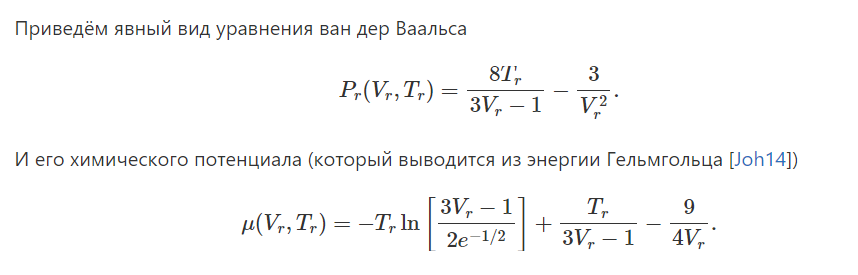

In [3]:
#! Ни к чему было модифицировать метод Бройдена под вашу функцию f(V, T) (она ниже определена)
#! Достаточно было создать замыкание f(V, T) под конкретную температуру
#!
#! constant_T = 0.9
#! Vinit = [foo, bar]
#! target_func(V) = f(V, constant_T)
#! broydensys(target_func, Vinit, Jacobian(Vinit, constant_T))

"""
    broydensys(f, x, J[; maxiter, xtol, ftol])

Решает нелинейную систему уравнений `f`(x) = 0 методом Бройдена.
Требует начального приближения корня `x` уравнения и якобиана `J` в этой точке.
Выполняет итерации, пока норма решения `> xtol` или норма функции `> ftol`.
В случае превышения числа итераций `maxiter` вызывает ошибку.
"""
function broydensys(f, x, T, J; maxiter=150, xtol=1e-6, ftol=1e-6)
    δx = float(similar(x))
    yp, yn = similar.((δx, δx))
    x = float(copy(x))
    B = float(copy(J))
    yn .= f(x, T)
    
    for i in 1:maxiter
        yp .= yn
        δx .= .- (B \ yp)
        x .+= δx
        yn .= f(x, T)

        norm(δx) < xtol && return x
        norm(yn) < ftol && return x
        
        g = B * δx
        B .+= (1 / dot(δx, δx)) .* (yn .- yp .- g) .* δx'
    end
    error("Превышено число итераций.")
end

broydensys

In [35]:
#! Диспатч
P_vdv(V::Real, T::Real) = 8*T / (3*V - 1) - 3 / (V^2)
der_P_vdv(V::Real, T::Real) = - 24*T / (3*V - 1)^2 + 6 / (V^3)

μ(V::Real, T::Real) = - T*log((3*V - 1) / (2*exp(-1/2))) + T / (3*V - 1) - 9 / (4*V)
der_μ(V::Real, T::Real) = - 6*T*exp(-1/2) / (3*V - 1) - T / (3*V -1)^2 + 36 / (16*V^2)

#! Это хорошо
function f(V, T)
    V1, V2 = V
    return [P_vdv(V1, T)-P_vdv(V2, T), μ(V1, T)-μ(V2, T)]
end

#! Это хорошо
function Jacobian(V, T)
    V1, V2 = V
    return [
        der_P_vdv(V1, T)-P_vdv(V2, T) P_vdv(V1, T)-der_P_vdv(V2, T);
        der_μ(V1, T)-μ(V2, T) μ(V1, T)-der_μ(V2, T)
    ]
end


Jacobian (generic function with 1 method)

#### Сюда больно смотреть, но как по-другому задать начальное приближение для каждого Т, чтобы под логарифмом на какой-то итерации не получалось отрицательное число, и не вылетала ошибка, я не знаю

Чтобы не так "больно" было смотреть, стоило температуры сохранить в переменную.
А то далее там циклы с одной итерацией.

In [20]:
V = [3.12, 0.55]
roots = []
for T in range(0.85, 0.99; step=0.02)[begin:5]
    push!(roots, broydensys(f, V, T, Jacobian(V, T)))
    V = roots[end] .+ 0.06     # поч? пот

    println(T)
    println("roots: ", roots)
    
    #! println
    println("new V: ", V)
end


0.85
roots: Any[[3.127634079867593, 0.5533604055952074]]
new V: [3.187634079867593, 0.6133604055952073]
0.87
roots: Any[[3.127634079867593, 0.5533604055952074], [2.7909058364124353, 0.5711590699581541]]
new V: [2.8509058364124353, 0.6311590699581542]
0.89
roots: Any[[3.127634079867593, 0.5533604055952074], [2.7909058364124353, 0.5711590699581541], [2.488881704204138, 0.5917627241248348]]
new V: [2.548881704204138, 0.6517627241248347]
0.91
roots: Any[[3.127634079867593, 0.5533604055952074], [2.7909058364124353, 0.5711590699581541], [2.488881704204138, 0.5917627241248348], [2.2150985372799084, 0.6161480565145374]]
new V: [2.2750985372799084, 0.6761480565145375]
0.93
roots: Any[[3.127634079867593, 0.5533604055952074], [2.7909058364124353, 0.5711590699581541], [2.488881704204138, 0.5917627241248348], [2.2150985372799084, 0.6161480565145374], [1.9634276686641938, 0.6459321584912188]]
new V: [2.0234276686641937, 0.7059321584912188]


In [22]:
V = [1.6, 0.7]
T = 0.95
push!(roots, broydensys(f, V, T, Jacobian(V, T)))
println(T)
print(broydensys(f, V, T, Jacobian(V, T)))

0.95
[1.7270698402560516, 0.6841220033609623]

In [23]:
V = [1.2, 0.6]
T = 0.97
push!(roots, broydensys(f, V, T, Jacobian(V, T)))
println(T)
print(broydensys(f, V, T, Jacobian(V, T)))


0.97
[1.4960194990630808, 0.7375546177839187]

In [24]:
V = [1.1, 0.85]
T = 0.99
push!(roots, broydensys(f, V, T, Jacobian(V, T)))
println(T)
print(broydensys(f, V, T, Jacobian(V, T)))

0.99
[1.2429204484538918, 0.8309022646174202]

In [92]:
#!
let
    T = 0.99
    Vinit = [1.1, 0.85]
    broydensys(f, Vinit, T, Jacobian(Vinit, T))
end

2-element Vector{Float64}:
 1.2429204484538918
 0.8309022646174202

#### Построим график

In [25]:
roots1 = []
roots2 = []
for i in range(1,8)
    push!(roots1, roots[i][1])
    push!(roots2, roots[i][2])
end
roots = vcat(roots1, roots2)

16-element Vector{Any}:
 3.127634079867593
 2.7909058364124353
 2.488881704204138
 2.2150985372799084
 1.9634276686641938
 1.7270698402560516
 1.4960194990630808
 1.2429204484538918
 0.5533604055952074
 0.5711590699581541
 0.5917627241248348
 0.6161480565145374
 0.6459321584912188
 0.6841220033609623
 0.7375546177839187
 0.8309022646174202

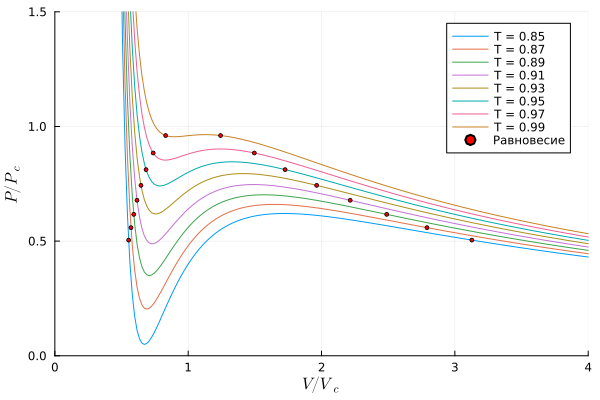

In [34]:
plt = plot(;
    ylim=(0., 1.5),
    xlim=(0., 4.),
    lw=2,
    xlabel=L"V/V_c",   # подпись оси X с LaTeX шрифтом
    ylabel=L"P/P_c",   # подпись оси Y с LaTeX шрифтом
)

left, right = [], []
V = collect(range(0.4, 4; length=200))
for (i, T) in enumerate(range(0.85, 0.99; step=0.02))
    plot!(V, P_vdv.(V, T); label="T = $(T)")  # подпись графика на легенде
    push!(left, P_vdv(roots[i], T))
    push!(right, P_vdv(roots[i+8], T))
end
scatter!(roots, vcat(left, right), label="Равновесие", marker=(:o, 2), color=:red)
plt